**Preparing the environment:**

In [ ]:
# Retrieving the dataset from the repository
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 39.50 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [ ]:
!pip3 install imgaug

**Importing project dependencies:**

In [ ]:
import ntpath
import os
import random

import cv2
import matplotlib.image as npimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
from imgaug import augmenters as iaa
from keras.layers import Convolution2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
data_directory = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

# Opening the CSV file to get the data from it
driving_data = pd.read_csv(os.path.join(data_directory, 'driving_log.csv'), names=columns)
# Defining the max size for the column so it does not truncate
pd.set_option('display.max_colwidth', None)
# Showing the first five rows of the data imported from the CSV file
driving_data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

**Formatting the data:**

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [ ]:
driving_data['center'] = driving_data['center'].apply(path_leaf)
driving_data['left'] = driving_data['left'].apply(path_leaf)
driving_data['right'] = driving_data['right'].apply(path_leaf)
driving_data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

Attributes description:

* center: an image taken from the center of the vehicle used in the simulation;
* left: an image taken from the left side of the vehicle used in the simulation;
* right: an image taken from the right side of the vehicle used in the simulation;
* steering: the steering angle applied to the vehicle in that frame;
* throttle: the throttle value applied to the vehicle in that frame;
* reverse: the value of the reverse speed if the vehicle was going backwards;
* speed: the current speed of the vehicle in that frame.





**Displaying the distribution of the dataset:**

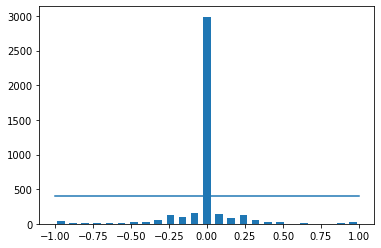

In [ ]:
number_of_bins = 25
samples_per_bin = 400
history, bins = np.histogram(a=driving_data['steering'], bins=number_of_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(x=center, height=history, width=0.05)
plt.plot((np.min(driving_data['steering']), np.max(driving_data['steering'])), (samples_per_bin, samples_per_bin))

**Flattening the data to avoid biased results:**

Total quantity of items:  4053
Quantity of removed items:  2590
Remaining quantity of items:  1463


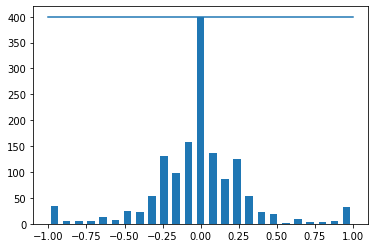

In [ ]:
print('Total quantity of items: ', len(driving_data))

remove_list = []

for j in range(number_of_bins):
  _list = []
  for i in range(len(driving_data['steering'])):
    if driving_data['steering'][i] >= bins[j] and driving_data['steering'][i] <= bins[j + 1]:
      _list.append(i)
  _list = shuffle(_list)
  _list = _list[samples_per_bin:]
  remove_list.extend(_list)

print('Quantity of removed items: ', len(remove_list))

driving_data.drop(driving_data.index[remove_list], inplace=True)

print('Remaining quantity of items: ', len(driving_data))

# Displaying the result after flattening the dataset
history, _ = np.histogram(driving_data['steering'], (number_of_bins))
plt.bar(x=center, height=history, width=0.05)
plt.plot((np.min(driving_data['steering']), np.max(driving_data['steering'])), (samples_per_bin, samples_per_bin))

**Image processing:**

In [ ]:
def load_image_steering(data_directory, data_frame):
  image_path = []
  steering = []
  for i in range(len(driving_data)):
    indexed_data = driving_data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_directory, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_image_steering(data_directory + '/IMG', driving_data)

In [ ]:
# Splits the datasets into training and validation datasets
X_training, X_validation, y_training, y_validation = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_training), len(X_validation)))

Training Samples: 1170
Validation Samples: 293


Text(0.5, 1.0, 'Validation Set')

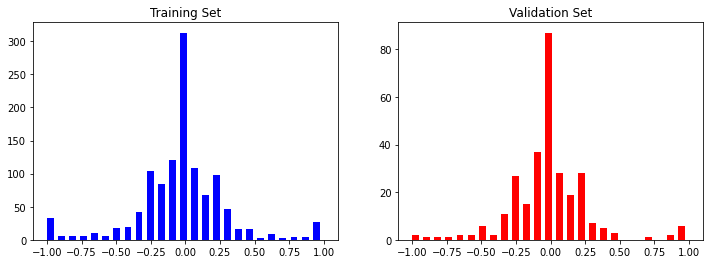

In [ ]:
# Displaying the distribution of data from both the training and validation sets
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].hist(y_training, bins=number_of_bins, width=0.05, color='blue')
axis[0].set_title('Training Set')
axis[1].hist(y_validation, bins=number_of_bins, width=0.05, color='red')
axis[1].set_title('Validation Set')

In [ ]:
def zoom(image):
  zoom_augment = iaa.Affine(scale=(1, 1.3))
  zoomed_image = zoom_augment.augment_image(image)
  return zoomed_image

Text(0.5, 1.0, 'Zoomed Image')

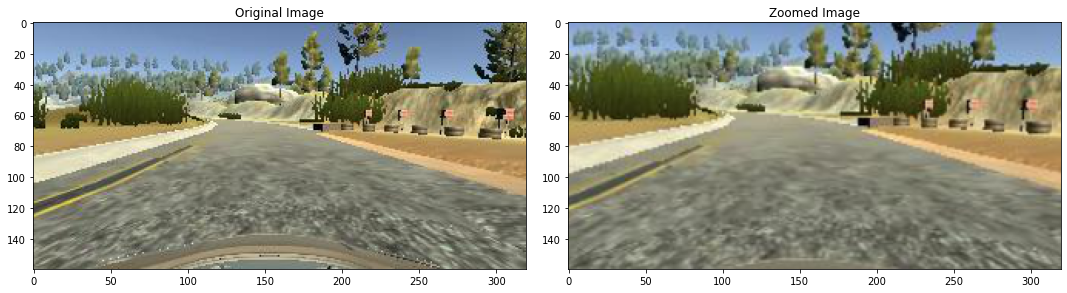

In [ ]:
image = image_paths[random.randint(0, len(image_paths) - 1)]
original_image = npimg.imread(image)
zoomed_image = zoom(original_image)

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original Image')

axis[1].imshow(zoomed_image)
axis[1].set_title('Zoomed Image')

In [ ]:
def pan(image):
  pan_augment = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  pan_image = pan_augment.augment_image(image)
  return pan_image

Text(0.5, 1.0, 'Panned Image')

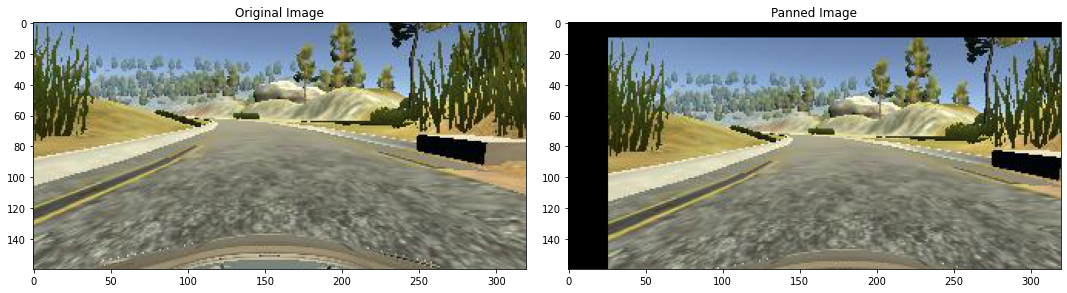

In [ ]:
image = image_paths[random.randint(0, len(image_paths) - 1)]
original_image = npimg.imread(image)
panned_image = pan(original_image)

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original Image')

axis[1].imshow(panned_image)
axis[1].set_title('Panned Image')

In [ ]:
def brightness(image):
  brightness_augment = iaa.Multiply(mul=(0.2, 1.2))
  bright_image = brightness_augment.augment_image(image)
  return bright_image

Text(0.5, 1.0, 'Brightned Image')

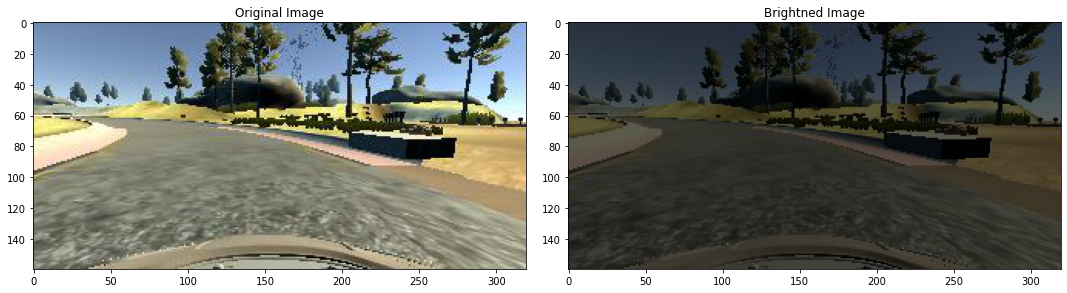

In [ ]:
image = image_paths[random.randint(0, len(image_paths) - 1)]
original_image = npimg.imread(image)
bright_image = brightness(original_image)

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original Image')

axis[1].imshow(bright_image)
axis[1].set_title('Brightned Image')

In [ ]:
def flip(image, steering_angle):
  flipped_image = cv2.flip(image, 1)
  negative_steering_angle = -steering_angle 
  return flipped_image, negative_steering_angle

Text(0.5, 1.0, 'Flipped Image -  Steering Angle: -0.06365231')

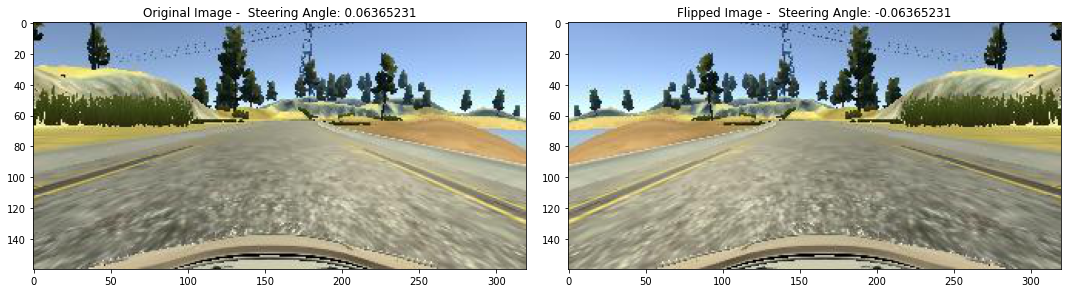

In [ ]:
random_index = random.randint(0, len(image_paths) - 1)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = npimg.imread(image)
flipped_image, flipped_steering_angle = flip(original_image, steering_angle)

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original Image' + ' - ' + ' Steering Angle: ' + str(steering_angle))

axis[1].imshow(flipped_image)
axis[1].set_title('Flipped Image' + ' - ' + ' Steering Angle: ' + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
  image_augment = npimg.imread(image)
  if np.random.rand() < 0.5:
    image_augment = zoom(image_augment)
  if np.random.rand() < 0.5:
    image_augment = pan(image_augment)
  if np.random.rand() < 0.5:
    image_augment = brightness(image_augment)
  if np.random.rand() < 0.5:
    image_augment, steering_angle = flip(image_augment, steering_angle)
  return image_augment, steering_angle


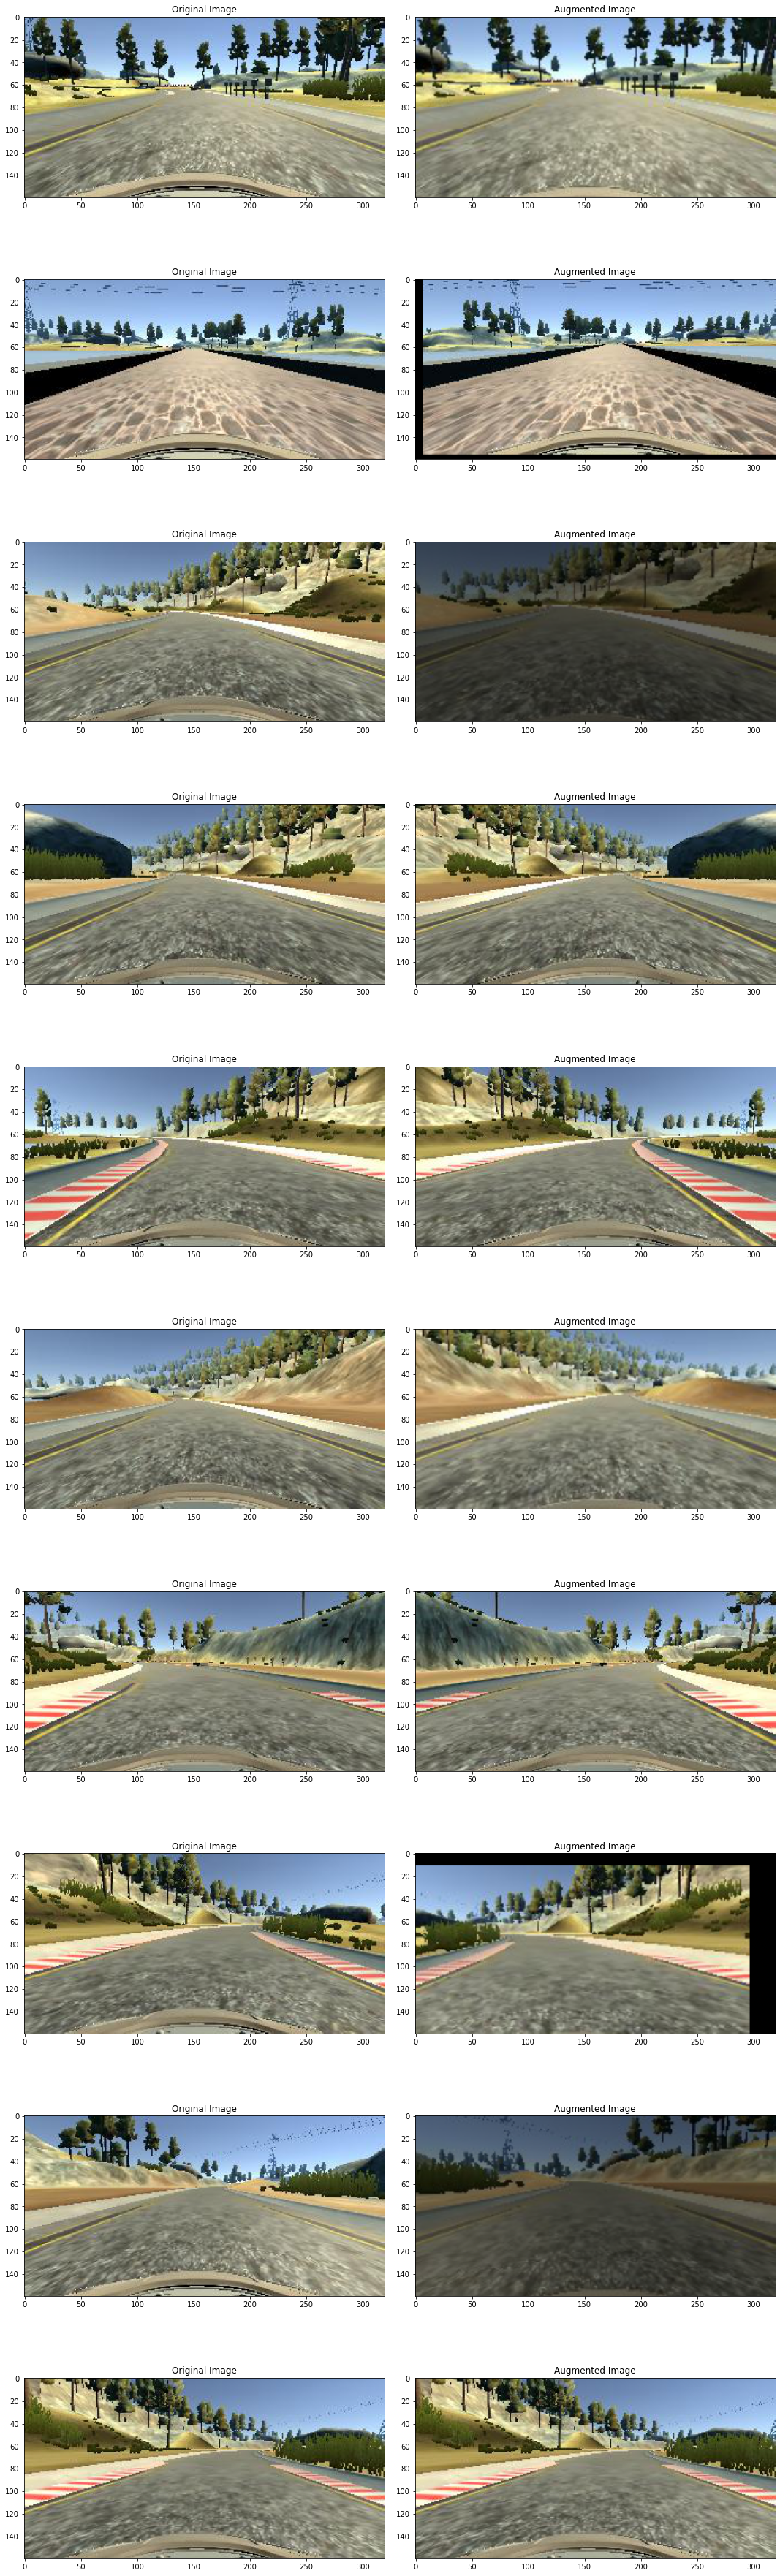

In [ ]:
columns = 2
rows = 10

figure, axis = plt.subplots(rows, columns, figsize=(15, 50))
figure.tight_layout()

for i in range(rows):
  random_number = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[random_number]
  random_steering = steerings[random_number]

  original_image = npimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axis[i][0].imshow(original_image)
  axis[i][0].set_title('Original Image')

  axis[i][1].imshow(augmented_image)
  axis[i][1].set_title('Augmented Image')

In [ ]:
def image_preprocess(img):
  img = img[60:135, :, :] # Cropping the height of the image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Using YUV instead of GRAYSCALE because we will use the NVidia Architecture for Deep Neural Networks
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66)) # Recommended size for the NVidia Architecture
  img = img / 255 # Normalization
  return img

Text(0.5, 1.0, 'Pre-Processed Image')

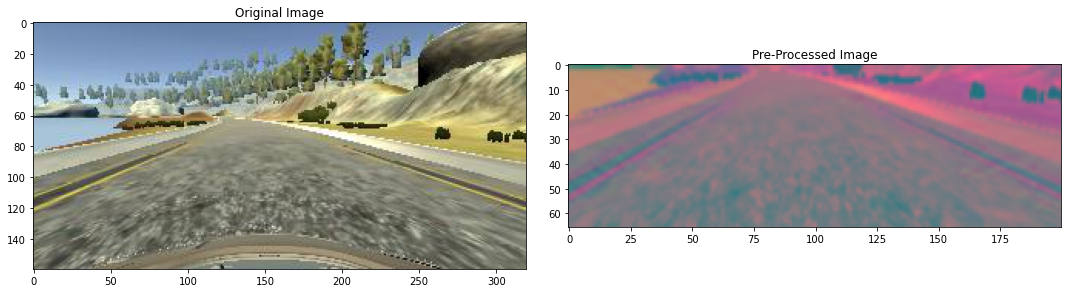

In [ ]:
image = image_paths[100]
original_image = npimg.imread(image)
pre_processed_image = image_preprocess(original_image)

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original Image')

axis[1].imshow(pre_processed_image)
axis[1].set_title('Pre-Processed Image')

In [ ]:
def batch_generator(images, steering_angles, batch_size, is_training):
  # Creating a batch of pre-processed images on-demand.
  # With this, we have full autonomy with the creation of valid images to use in the model,
  # also, because this is all executed on-demand, we avoid bottlenecks in computational power.
  while True:
    batch_image = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(images) - 1)
      if is_training:
        image, steering = random_augment(images[random_index], steering_angles[random_index])
      else:
        image = npimg.imread(images[random_index])
        steering = steering_angles[random_index]
      processed_image = image_preprocess(image)
      batch_image.append(processed_image)
      batch_steering.append(steering)
    yield (np.asarray(batch_image), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

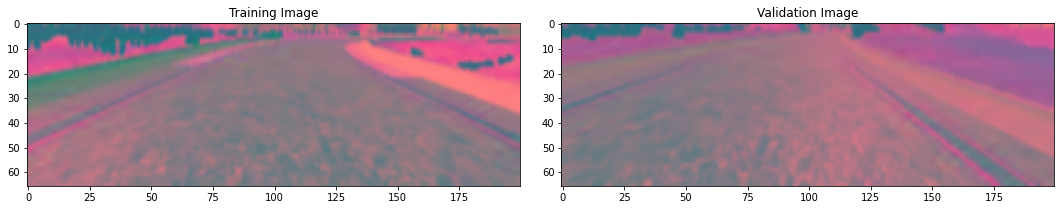

In [ ]:
# Generating the images dataset using the batch generator on-demand for both the training and validation sets
X_training_generated, y_training_generated = next(batch_generator(X_training, y_training, 1, 1))
X_validation_generated, y_validation_generated = next(batch_generator(X_validation, y_validation, 1, 0))

figure, axis = plt.subplots(1, 2, figsize=(15, 10))
figure.tight_layout()

axis[0].imshow(X_training_generated[0])
axis[0].set_title('Training Image')

axis[1].imshow(X_validation_generated[0])
axis[1].set_title('Validation Image')

**Deep Neural Network algorithm:**

In [ ]:
def create_nvidia_model():
  new_model = Sequential()
  new_model.add(Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  new_model.add(Convolution2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  new_model.add(Convolution2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  new_model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='elu'))
  new_model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='elu'))
  # new_model.add(Dropout(rate=0.5))

  new_model.add(Flatten())

  new_model.add(Dense(units=100, activation='elu'))
  # new_model.add(Dropout(rate=0.5))
  new_model.add(Dense(units=50, activation='elu'))
  # new_model.add(Dropout(rate=0.5))
  new_model.add(Dense(units=10, activation='elu'))
  # new_model.add(Dropout(rate=0.5))
  new_model.add(Dense(units=1))

  adam_optimizer = Adam(learning_rate=1e-4)
  new_model.compile(loss='mse', optimizer=adam_optimizer)
  return new_model

In [ ]:
model = create_nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [ ]:
# Training the model
history = model.fit_generator(generator=batch_generator(X_training, y_training, 100, 1), steps_per_epoch=300, epochs=10, validation_data=batch_generator(X_validation, y_validation, 100, 0), validation_steps=200, verbose=1, shuffle=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
300/300 [==============================] - 179s 596ms/step - loss: 0.0841 - val_loss: 0.0542
Epoch 2/10
300/300 [==============================] - 180s 600ms/step - loss: 0.0629 - val_loss: 0.0546
Epoch 3/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0581 - val_loss: 0.0492
Epoch 4/10
300/300 [==============================] - 179s 598ms/step - loss: 0.0527 - val_loss: 0.0464
Epoch 5/10
300/300 [==============================] - 180s 600ms/step - loss: 0.0473 - val_loss: 0.0402
Epoch 6/10
300/300 [==============================] - 180s 599ms/step - loss: 0.0422 - val_loss: 0.0407
Epoch 7/10
300/300 [==============================] - 181s 603ms/step - loss: 0.0400 - val_loss: 0.0371
Epoch 8/10
300/300 [==============================] - 181s 602ms/step - loss: 0.0372 - val_loss: 0.0347
Epoch 9/10
300/300 [==============================] - 180s 600ms/step - loss: 0.0354 - val_l

Text(0.5, 0, 'Epoch')

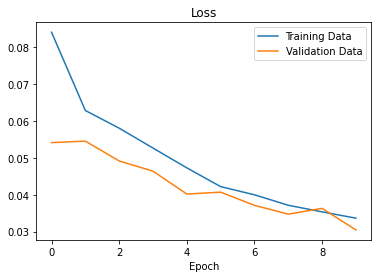

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Data', 'Validation Data'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
# Exporting the model
model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>